In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
import gc; gc.enable()


%matplotlib inline

In [2]:
df = pd.read_csv('./data/data.csv')

In [3]:
df=df.rename(columns = {"Unnamed: 0": "Date"})

In [4]:
df.tail()

,Date,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
145915,2017-04-24 19:00:00,16984.175000,1291.972222,1768.647222,654.152778,1058.680556,1062.383333,2238.380556,855.547222,289.441667,5559.388889,487.286111,1718.294444,NaN
145916,2017-04-24 20:00:00,17615.657540,1341.735714,1843.365873,683.256349,1108.247222,1122.049603,2388.324206,884.457540,311.366270,5647.025397,498.217460,1787.611905,NaN
145917,2017-04-24 21:00:00,17200.752778,1290.469444,1801.922222,675.925000,1091.652778,1086.563889,2318.411111,846.966667,290.966667,5521.511111,492.600000,1783.763889,NaN
145918,2017-04-24 22:00:00,16148.388889,1193.955556,1687.572222,641.322222,1011.200000,1007.902778,2140.886111,776.563889,258.008333,5256.850000,475.905556,1698.222222,NaN
145919,2017-04-24 23:00:00,14931.883333,1092.930556,1577.530556,583.055556,933.863889,920.994444,1937.283333,699.247222,231.258333,4895.633333,460.969444,1599.116667,NaN


In [5]:
df.Date = pd.to_datetime(df.Date)

In [6]:
df.set_index('Date', inplace = True)

In [7]:
df.sort_index(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145920 entries, 2003-01-01 00:00:00 to 2019-07-31 23:00:00
Data columns (total 13 columns):
Load             145290 non-null float64
CAPITL           145290 non-null float64
CENTRL           145290 non-null float64
DUNWOD           145290 non-null float64
GENESE           145290 non-null float64
HUD VL           145290 non-null float64
LONGIL           127065 non-null float64
MHK VL           145290 non-null float64
MILLWD           145290 non-null float64
N.Y.C.           127065 non-null float64
NORTH            145290 non-null float64
WEST             145290 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 15.6 MB


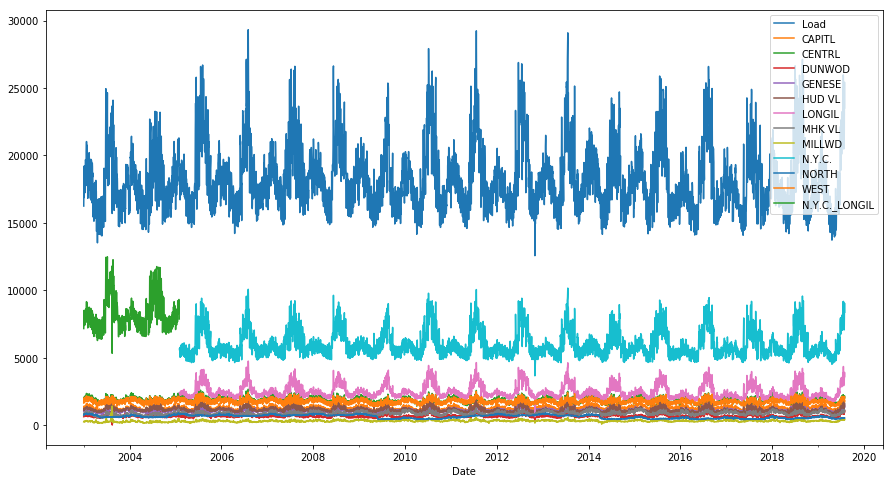

In [9]:
days = df.resample("D")
days_=days.mean()
days_.plot(kind = 'line', figsize=(15, 8))
plt.show()

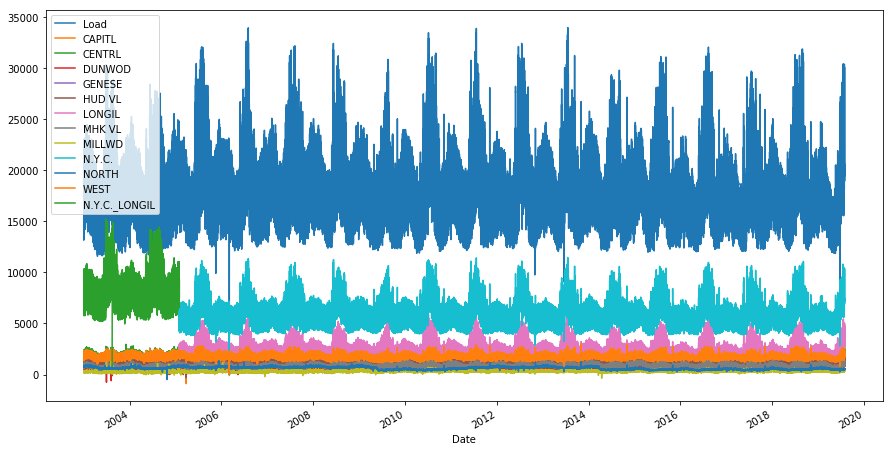

In [10]:
df.plot(kind = 'line', figsize=(15, 8))
plt.show()

In [11]:
df.tail()

,Load,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST,N.Y.C._LONGIL
Date,,,,,,,,,,,,,
2019-07-31 19:00:00,24835.000000,1947.066667,2294.158333,964.691667,1518.908333,1498.525000,3807.300000,1143.666667,430.083333,8408.100000,585.041667,2237.458333,NaN
2019-07-31 20:00:00,24219.675000,1896.200000,2219.283333,948.775000,1435.250000,1473.858333,3710.075000,1124.775000,435.516667,8286.316667,550.741667,2138.883333,NaN
2019-07-31 21:00:00,23578.041667,1842.125000,2147.391667,921.316667,1390.575000,1420.908333,3560.058333,1093.925000,423.700000,8140.341667,539.916667,2097.783333,NaN
2019-07-31 22:00:00,22177.316667,1699.375000,1982.983333,867.841667,1269.191667,1321.225000,3282.200000,1007.658333,387.158333,7849.108333,518.491667,1992.083333,NaN
2019-07-31 23:00:00,20562.291667,1551.416667,1798.033333,803.283333,1161.616667,1214.883333,2986.000000,914.350000,352.566667,7434.916667,514.658333,1830.566667,NaN


In [12]:
def get_slope(y):
    x = range(len(y))
    slope = np.polyfit(x, y, 1)[0]
    return slope

In [13]:
def get_acceleration(y):
    x = range(len(y))
    acc = 0.5*np.polyfit(x, y, 2)[0]
    return acc

In [14]:
def cyc_feats(df, feat):
    start = df.index[0].date().year-1
    df['cyc_{0}_x'.format(str(feat))] = np.cos(((2*np.pi)/df[feat])*(df['year']-(start))) #x-coord
    df['cyc_{0}_y'.format(str(feat))] = np.sin(((2*np.pi)/df[feat])*(df['year']-(start))) #y-coord
    return df

In [285]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    for i in [14, 28, 60]:
        df['MA_{0}'.format(str(i))] = df['Load'].rolling(24*i).mean() # rolling average
        df['MMAX_{0}'.format(str(i))] = df['Load'].rolling(24*i).max() # rolling maximum
        df['MMIN_{0}'.format(str(i))] = df['Load'].rolling(24*i).min() # rolling minimum
        df['MSTD_{0}'.format(str(i))] = df['Load'].rolling(24*i).std() # rolling standard deviation
        df['MSLOPE_{0}'.format(str(i))] = df['Load'].rolling(24*i).apply(lambda x: get_slope(x), raw=True) # rolling slope
        df['MACC_{0}'.format(str(i))] = df['Load'].rolling(24*i).apply(lambda x: get_acceleration(x),raw=True) # rolling acceleration
    for i in [1, 7, 30, 60, 90, 180]:
        # add the lagged Load as a feature
        df['lag_{0}'.format(str(i))] = df['Load'].shift(24*i)
        # as well as the percentage of the current Load for each lagged closing price
        df['pct_{0}'.format(str(i))] = df['lag_{0}'.format(str(i))] / df['Load']
   
    #create cyclical features
    feats = ['month', 'dayofmonth', 'dayofyear', 'weekofyear']
    for feat in feats:
        df = cyc_feats(df, feat)
    return df

In [16]:
def split_data(data, start_date, split_date):
    return data[(start_date) : (split_date)].copy(), \
               data[data.index >  split_date].copy()

In [17]:
def data_prep(data, isTest=0):
    used_cols = [col for col in data.columns.tolist() if col not in [target, _id]]
    keep_cols = used_cols
    if isTest:
        pass
    else:
        keep_cols += [target]
    used_cols = [col for col in keep_cols if col not in [target, _id]]
    return data[keep_cols].copy(), keep_cols, used_cols

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145920 entries, 2003-01-01 00:00:00 to 2019-07-31 23:00:00
Data columns (total 13 columns):
Load             145290 non-null float64
CAPITL           145290 non-null float64
CENTRL           145290 non-null float64
DUNWOD           145290 non-null float64
GENESE           145290 non-null float64
HUD VL           145290 non-null float64
LONGIL           127065 non-null float64
MHK VL           145290 non-null float64
MILLWD           145290 non-null float64
N.Y.C.           127065 non-null float64
NORTH            145290 non-null float64
WEST             145290 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 20.6 MB


In [19]:
df.isna().sum()

Load                630
CAPITL              630
CENTRL              630
DUNWOD              630
GENESE              630
HUD VL              630
LONGIL            18855
MHK VL              630
MILLWD              630
N.Y.C.            18855
NORTH               630
WEST                630
N.Y.C._LONGIL    127695
dtype: int64

In [20]:
#drop NaNs
target = 'Load'
df.dropna(subset = [target], inplace=True)
df.isna().sum()

Load                  0
CAPITL                0
CENTRL                0
DUNWOD                0
GENESE                0
HUD VL                0
LONGIL            18225
MHK VL                0
MILLWD                0
N.Y.C.            18225
NORTH                 0
WEST                  0
N.Y.C._LONGIL    127065
dtype: int64

In [21]:
df.shape

(145290, 13)

In [22]:
drop_cols = [col for col in df.columns.tolist() if col not in [target]]

In [23]:
df.drop(drop_cols, axis=1, inplace=True)

In [24]:
df.head()

,Load
Date,
2003-01-01 00:00:00,15415.625000
2003-01-01 01:00:00,14569.928571
2003-01-01 02:00:00,13812.200000
2003-01-01 03:00:00,13315.333333
2003-01-01 04:00:00,13156.333333


In [286]:
df_ = df['01-2017':].copy()

In [287]:
df_ = create_features(df_)

In [288]:
df_ = df_.dropna()

In [289]:
df_.head()

,Load,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,lag_180,pct_180,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-30 01:00:00,16817.233333,2017-06-30 01:00:00,1,4,2,6,2017,181,30,26,...,15763.208333,0.937325,0.5,0.866025,0.978148,0.207912,0.999398,0.034707,0.970942,0.239316
2017-06-30 02:00:00,16191.800000,2017-06-30 02:00:00,2,4,2,6,2017,181,30,26,...,15071.408333,0.930805,0.5,0.866025,0.978148,0.207912,0.999398,0.034707,0.970942,0.239316
2017-06-30 03:00:00,15843.775000,2017-06-30 03:00:00,3,4,2,6,2017,181,30,26,...,14485.033333,0.914241,0.5,0.866025,0.978148,0.207912,0.999398,0.034707,0.970942,0.239316
2017-06-30 04:00:00,15844.000000,2017-06-30 04:00:00,4,4,2,6,2017,181,30,26,...,14097.658333,0.889779,0.5,0.866025,0.978148,0.207912,0.999398,0.034707,0.970942,0.239316
2017-06-30 05:00:00,16355.541667,2017-06-30 05:00:00,5,4,2,6,2017,181,30,26,...,13937.300000,0.852145,0.5,0.866025,0.978148,0.207912,0.999398,0.034707,0.970942,0.239316


In [290]:
df_.tail()

,Load,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,lag_180,pct_180,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-31 19:00:00,24835.000000,2019-07-31 19:00:00,19,2,3,7,2019,212,31,31,...,23179.325000,0.933333,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 20:00:00,24219.675000,2019-07-31 20:00:00,20,2,3,7,2019,212,31,31,...,22868.250000,0.944201,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 21:00:00,23578.041667,2019-07-31 21:00:00,21,2,3,7,2019,212,31,31,...,22355.966667,0.948169,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 22:00:00,22177.316667,2019-07-31 22:00:00,22,2,3,7,2019,212,31,31,...,21700.475000,0.978499,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 23:00:00,20562.291667,2019-07-31 23:00:00,23,2,3,7,2019,212,31,31,...,20734.116667,1.008356,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268


In [291]:
df_.shape

(18285, 48)

In [292]:
df_[target] = df_[target].shift(-24)

In [293]:
df_.isna().sum()

Load                24
date                 0
hour                 0
dayofweek            0
quarter              0
month                0
year                 0
dayofyear            0
dayofmonth           0
weekofyear           0
MA_14                0
MMAX_14              0
MMIN_14              0
MSTD_14              0
MSLOPE_14            0
MACC_14              0
MA_28                0
MMAX_28              0
MMIN_28              0
MSTD_28              0
MSLOPE_28            0
MACC_28              0
MA_60                0
MMAX_60              0
MMIN_60              0
MSTD_60              0
MSLOPE_60            0
MACC_60              0
lag_1                0
pct_1                0
lag_7                0
pct_7                0
lag_30               0
pct_30               0
lag_60               0
pct_60               0
lag_90               0
pct_90               0
lag_180              0
pct_180              0
cyc_month_x          0
cyc_month_y          0
cyc_dayofmonth_x     0
cyc_dayofmo

In [294]:
df_.shape

(18285, 48)

In [295]:
df_.head()

,Load,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,lag_180,pct_180,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-30 01:00:00,18074.008333,2017-06-30 01:00:00,1,4,2,6,2017,181,30,26,...,15763.208333,0.937325,0.5,0.866025,0.978148,0.207912,0.999398,0.034707,0.970942,0.239316
2017-06-30 02:00:00,17242.416667,2017-06-30 02:00:00,2,4,2,6,2017,181,30,26,...,15071.408333,0.930805,0.5,0.866025,0.978148,0.207912,0.999398,0.034707,0.970942,0.239316
2017-06-30 03:00:00,16696.200000,2017-06-30 03:00:00,3,4,2,6,2017,181,30,26,...,14485.033333,0.914241,0.5,0.866025,0.978148,0.207912,0.999398,0.034707,0.970942,0.239316
2017-06-30 04:00:00,16374.500000,2017-06-30 04:00:00,4,4,2,6,2017,181,30,26,...,14097.658333,0.889779,0.5,0.866025,0.978148,0.207912,0.999398,0.034707,0.970942,0.239316
2017-06-30 05:00:00,16305.941667,2017-06-30 05:00:00,5,4,2,6,2017,181,30,26,...,13937.300000,0.852145,0.5,0.866025,0.978148,0.207912,0.999398,0.034707,0.970942,0.239316


In [296]:
df_.tail(25)

,Load,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,lag_180,pct_180,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-30 23:00:00,20562.291667,2019-07-30 23:00:00,23,1,3,7,2019,211,30,31,...,21540.466667,0.924423,-0.900969,0.433884,0.809017,0.587785,0.996012,0.089216,0.820763,0.571268
2019-07-31 00:00:00,NaN,2019-07-31 00:00:00,0,2,3,7,2019,212,31,31,...,20279.516667,0.936367,-0.900969,0.433884,0.820763,0.571268,0.996050,0.088796,0.820763,0.571268
2019-07-31 01:00:00,NaN,2019-07-31 01:00:00,1,2,3,7,2019,212,31,31,...,19446.441667,0.949075,-0.900969,0.433884,0.820763,0.571268,0.996050,0.088796,0.820763,0.571268
2019-07-31 02:00:00,NaN,2019-07-31 02:00:00,2,2,3,7,2019,212,31,31,...,18989.925000,0.966513,-0.900969,0.433884,0.820763,0.571268,0.996050,0.088796,0.820763,0.571268
2019-07-31 03:00:00,NaN,2019-07-31 03:00:00,3,2,3,7,2019,212,31,31,...,18647.400000,0.976749,-0.900969,0.433884,0.820763,0.571268,0.996050,0.088796,0.820763,0.571268
2019-07-31 04:00:00,NaN,2019-07-31 04:00:00,4,2,3,7,2019,212,31,31,...,18550.258333,0.980080,-0.900969,0.433884,0.820763,0.571268,0.996050,0.088796,0.820763,0.571268
2019-07-31 05:00:00,NaN,2019-07-31 05:00:00,5,2,3,7,2019,212,31,31,...,18735.875000,0.967074,-0.900969,0.433884,0.820763,0.571268,0.996050,0.088796,0.820763,0.571268
2019-07-31 06:00:00,NaN,2019-07-31 06:00:00,6,2,3,7,2019,212,31,31,...,19508.866667,0.954720,-0.900969,0.433884,0.820763,0.571268,0.996050,0.088796,0.820763,0.571268
2019-07-31 07:00:00,NaN,2019-07-31 07:00:00,7,2,3,7,2019,212,31,31,...,21137.125000,0.962064,-0.900969,0.433884,0.820763,0.571268,0.996050,0.088796,0.820763,0.571268


In [44]:
# df = create_features(df)


In [45]:
# df.dropna().head()

,Load
Date,
2003-01-01 00:00:00,15415.625000
2003-01-01 01:00:00,14569.928571
2003-01-01 02:00:00,13812.200000
2003-01-01 03:00:00,13315.333333
2003-01-01 04:00:00,13156.333333


In [65]:
# df[target] = df[target].shift(-24)

In [ ]:
df.head(25)

In [297]:
train, test = split_data(df_,'01-01-2017', '07-30-2019')

In [298]:
_id = 'date'
train, keep_cols, used_cols = data_prep(train)
test, keep_cols, used_cols = data_prep(test, isTest=1)

In [299]:
train.isna().sum()

hour                0
dayofweek           0
quarter             0
month               0
year                0
dayofyear           0
dayofmonth          0
weekofyear          0
MA_14               0
MMAX_14             0
MMIN_14             0
MSTD_14             0
MSLOPE_14           0
MACC_14             0
MA_28               0
MMAX_28             0
MMIN_28             0
MSTD_28             0
MSLOPE_28           0
MACC_28             0
MA_60               0
MMAX_60             0
MMIN_60             0
MSTD_60             0
MSLOPE_60           0
MACC_60             0
lag_1               0
pct_1               0
lag_7               0
pct_7               0
lag_30              0
pct_30              0
lag_60              0
pct_60              0
lag_90              0
pct_90              0
lag_180             0
pct_180             0
cyc_month_x         0
cyc_month_y         0
cyc_dayofmonth_x    0
cyc_dayofmonth_y    0
cyc_dayofyear_x     0
cyc_dayofyear_y     0
cyc_weekofyear_x    0
cyc_weekof

In [300]:
X_train = train[keep_cols].copy()
y_train = train[target].copy()
X_test = df_['07-31-2019'][used_cols].copy()
y_test = df['07-31-2019'][target].copy()

In [301]:
X_test.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MA_14,MMAX_14,...,lag_180,pct_180,cyc_month_x,cyc_month_y,cyc_dayofmonth_x,cyc_dayofmonth_y,cyc_dayofyear_x,cyc_dayofyear_y,cyc_weekofyear_x,cyc_weekofyear_y
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-31 00:00:00,0,2,3,7,2019,212,31,31,23206.138459,30412.158333,...,20279.516667,0.936367,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 01:00:00,1,2,3,7,2019,212,31,31,23205.452447,30412.158333,...,19446.441667,0.949075,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 02:00:00,2,2,3,7,2019,212,31,31,23204.602893,30412.158333,...,18989.925000,0.966513,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 03:00:00,3,2,3,7,2019,212,31,31,23203.676827,30412.158333,...,18647.400000,0.976749,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268
2019-07-31 04:00:00,4,2,3,7,2019,212,31,31,23202.638409,30412.158333,...,18550.258333,0.980080,-0.900969,0.433884,0.820763,0.571268,0.99605,0.088796,0.820763,0.571268


In [302]:
X_train.isna().sum()

hour                0
dayofweek           0
quarter             0
month               0
year                0
dayofyear           0
dayofmonth          0
weekofyear          0
MA_14               0
MMAX_14             0
MMIN_14             0
MSTD_14             0
MSLOPE_14           0
MACC_14             0
MA_28               0
MMAX_28             0
MMIN_28             0
MSTD_28             0
MSLOPE_28           0
MACC_28             0
MA_60               0
MMAX_60             0
MMIN_60             0
MSTD_60             0
MSLOPE_60           0
MACC_60             0
lag_1               0
pct_1               0
lag_7               0
pct_7               0
lag_30              0
pct_30              0
lag_60              0
pct_60              0
lag_90              0
pct_90              0
lag_180             0
pct_180             0
cyc_month_x         0
cyc_month_y         0
cyc_dayofmonth_x    0
cyc_dayofmonth_y    0
cyc_dayofyear_x     0
cyc_dayofyear_y     0
cyc_weekofyear_x    0
cyc_weekof

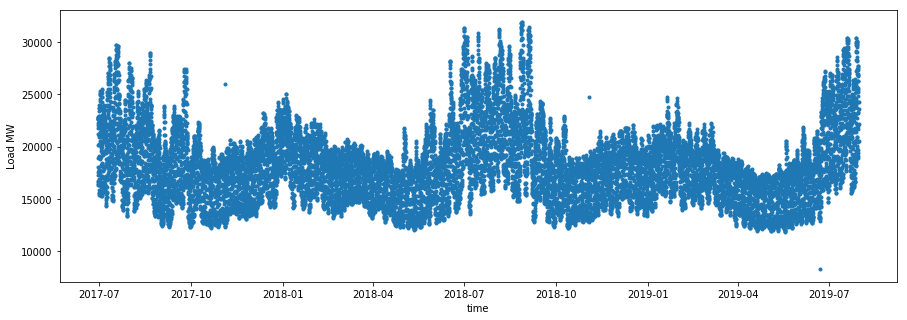

In [303]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('Load MW')
plt.plot(X_train.index,y_train, '.')
# plt.plot(X_test.index,y_test, '.')
plt.show()

In [304]:
X_train.shape

(18261, 46)

In [305]:
y_train

Date
2017-06-30 01:00:00    18074.008333
2017-06-30 02:00:00    17242.416667
2017-06-30 03:00:00    16696.200000
2017-06-30 04:00:00    16374.500000
2017-06-30 05:00:00    16305.941667
2017-06-30 06:00:00    16655.575000
2017-06-30 07:00:00    17595.125000
2017-06-30 08:00:00    18897.991667
2017-06-30 09:00:00    20155.066667
2017-06-30 10:00:00    21201.208333
2017-06-30 11:00:00    22044.608333
2017-06-30 12:00:00    22640.941667
2017-06-30 13:00:00    22862.708333
2017-06-30 14:00:00    22784.416667
2017-06-30 15:00:00    22607.533333
2017-06-30 16:00:00    22693.833333
2017-06-30 17:00:00    22670.875000
2017-06-30 18:00:00    22207.666667
2017-06-30 19:00:00    21738.733333
2017-06-30 20:00:00    21104.008333
2017-06-30 21:00:00    20924.841667
2017-06-30 22:00:00    20149.625000
2017-06-30 23:00:00    18978.733333
2017-07-01 00:00:00    17801.533333
2017-07-01 01:00:00    16934.483333
2017-07-01 02:00:00    16292.450000
2017-07-01 03:00:00    15860.125000
2017-07-01 04:00:00    

In [306]:
y_train.isna().sum()

0

In [307]:
X_train.shape, y_train.shape

((18261, 46), (18261,))

In [308]:
X_test.shape

(24, 46)

In [309]:
y_test.shape

(24,)

In [310]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [311]:
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        early_stopping_rounds=24, 
        verbose=False) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

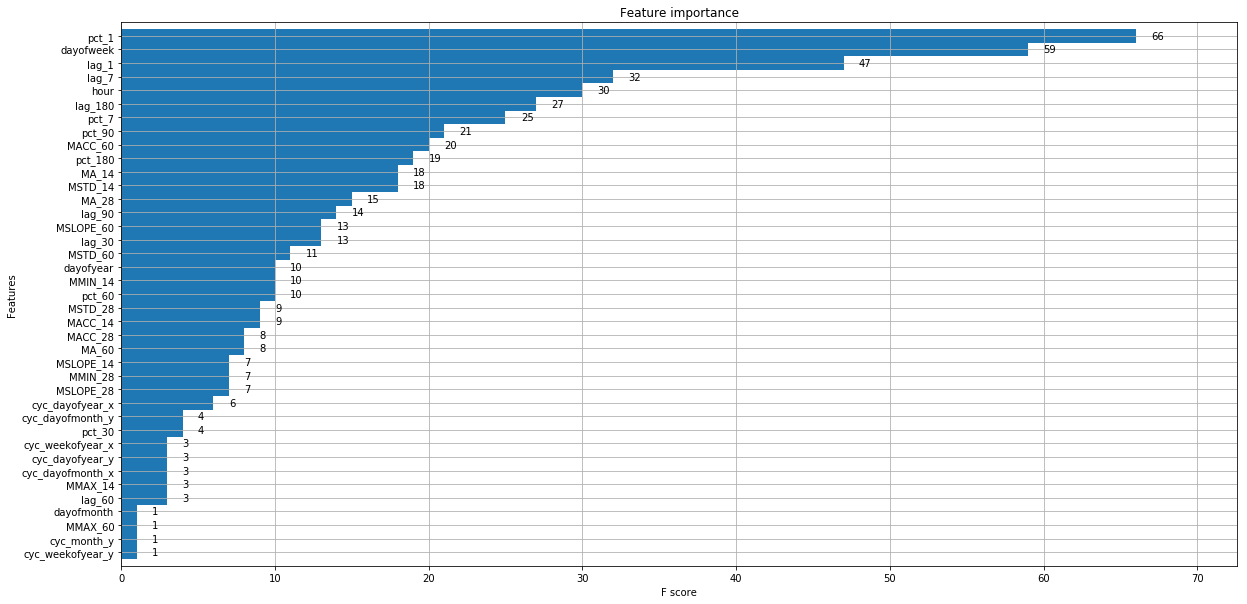

In [312]:
plt.rcParams["figure.figsize"] = (20, 10)
xgb.plot_importance(reg, height = 1)

In [313]:
# feats = reg.get_booster().get_score(importance_type="weight")
# feats

In [314]:
y_pred = reg.predict(X_test)


In [315]:
len(y_pred)

24

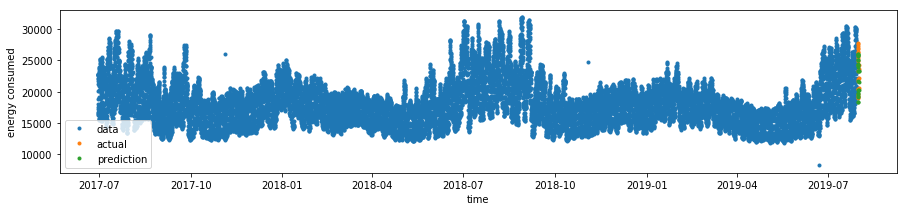

In [316]:
plt.figure(figsize=(15,3))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(X_train.index, y_train, '.', label='data')
plt.plot(X_test.index, y_test, '.', label='actual')
plt.plot(X_test.index, y_pred, '.', label='prediction')
plt.legend()
# plt.xlim(left=date_from, right=date_to)
plt.show()

In [317]:
def plot_(data, target, begin, end, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(begin, end))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(data.index, target, '-', label='data')
    plt.plot(X_test.index, y_pred, '-', label='prediction')
    plt.legend()
    plt.xlim(left=begin, right=end)

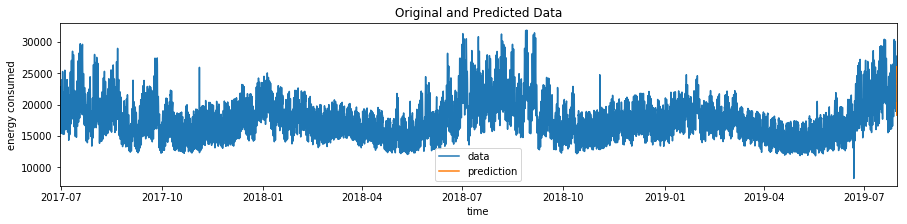

In [336]:
plot_(df_, df_[target], df_.index[0].date(), df_.index[-1].date(), 'Original and Predicted Data')

/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=737271.0, right=737271.0
  ret = ax.set_xlim(*args, **kwargs)


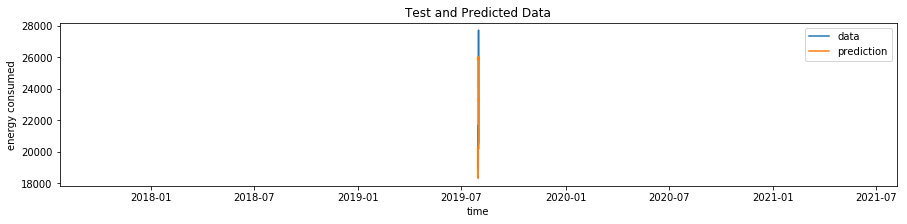

In [319]:
plot_(X_test, y_test, y_test.index[0].date(), y_test.index[-1].date(), 'Test and Predicted Data')

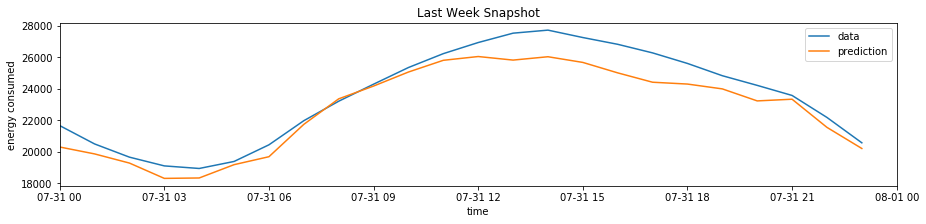

In [322]:
plot_(X_test, y_test, '07-31-2019', '08-01-2019', 'Last Week Snapshot')

In [323]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from numba import jit
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [324]:
def forecast_error(y_true, y_pred):
    return y_true - y_pred

In [325]:
def mean_forecast_error(forecast_error):
    return forecast_error.mean()

In [326]:
def smape(A, F):
    return (100/len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [327]:
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

In [328]:
MSE = mean_squared_error(y_test, y_pred)
print(MSE)

1012043.5708345519


In [329]:
MAE = mean_absolute_error(y_test, y_pred)
print(MAE)

829.33347594246


In [330]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(MAPE)

3.4150498145546457


In [331]:
sMAPE = smape(y_test, y_pred)
print(sMAPE)

3.497325531713482


In [332]:
RMSE = np.sqrt(MSE)
print(RMSE)

1006.0037628331974


In [333]:
FE = forecast_error(y_test, y_pred)
MFE = mean_forecast_error(FE)
print(MFE)

816.6423518105157


In [334]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

0.8812508549537102


In [335]:
sMAPE_2 = smape_fast(y_test, y_pred)
print(sMAPE_2)

3.497325531713482


In [284]:
idx = pd.date_range('2019-08-01', periods=(7)*24, freq='H')
X_7 = pd.DataFrame(idx, columns=['Date'])

In [225]:
X_7.set_index('Date', inplace = True)

In [64]:
X_7 = create_features(X_7)

KeyError: 'Load'